In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from minisom import MiniSom
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay
)

rng = np.random.RandomState(42)

In [89]:
train_df = pd.read_csv("Tables/bnpl_train.csv")
test_df = pd.read_csv("Tables/bnpl_test.csv")
val_df = pd.read_csv("Tables/bnpl_val.csv")
target_col = "default_flag"

In [90]:
print(train_df.shape, test_df.shape, val_df.shape)
print(train_df.head(),test_df.head(), val_df.head())
print("Train nulls in target:", train_df["default_flag"].isna().sum())
print("Train class distribution:\n", train_df["default_flag"].value_counts(normalize=True))

(595, 14) (199, 14) (199, 14)
   external_repayment_loans  credit_card_interest_incidence  default_flag  \
0                         1                               0             0   
1                         0                               0             0   
2                         0                               0             0   
3                         0                               1             0   
4                         1                               1             0   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.730258               -1.246089                 -1.746734   
1              1.319109                0.529472                 -0.222965   
2              0.408279                1.239697                  0.805578   
3             -1.641088                1.594809                 -0.184871   
4              0.408279                0.529472                 -1.556263   

   payment_delinquency_count  impulsive_buyi

In [91]:
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
print("X_train shape:", X_train.shape, X_train.head())
print("y_train shape:", y_train.shape, y_train.head())
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]
print("X_test shape:", X_test.shape, X_test.head())
print("y_test shape:", y_test.shape, y_test.head())
X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]
print("X_val shape:", X_val.shape, X_val.head())
print("y_val shape:", y_val.shape, y_val.head())

X_train shape: (595, 13)    external_repayment_loans  credit_card_interest_incidence  \
0                         1                               0   
1                         0                               0   
2                         0                               0   
3                         0                               1   
4                         1                               1   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.730258               -1.246089                 -1.746734   
1              1.319109                0.529472                 -0.222965   
2              0.408279                1.239697                  0.805578   
3             -1.641088                1.594809                 -0.184871   
4              0.408279                0.529472                 -1.556263   

   payment_delinquency_count  impulsive_buying_score  \
0                  -1.500097               -0.528311   
1                  -1

In [92]:
def som_size_heuristic(n_samples: int):
    """Pick a roughly square grid; total units ≈ 5 * sqrt(N_train)."""
    tu = int(max(4, round(5 * np.sqrt(max(1, n_samples)))))
    m = int(round(np.sqrt(tu)))
    n = max(2, int(round(tu / m)))
    return m, n

In [93]:
def fit_som(X_train, m=None, n=None, total_units=None, sigma='auto',
            learning_rate=0.5, neighborhood_function='gaussian',
            num_iteration='auto', random_state=42):
    """
    Fit a MiniSom on TRAIN ONLY.
    - Grid size: choose via (m, n) or total_units, else use heuristic.
    - sigma='auto' -> neighborhood radius starts at ~half the largest grid dim.
    - num_iteration='auto' -> ~10 * n_train updates (tweak if big).
    """
    X = np.asarray(X_train, dtype=float)
    n_samples, n_features = X.shape

    # decide grid shape
    if m is None or n is None:
        if total_units is not None:
            m = int(round(np.sqrt(total_units)))
            n = max(2, int(round(total_units / m)))
        else:
            m, n = som_size_heuristic(n_samples)

    if sigma == 'auto':
        sigma = max(m, n) / 2.0
    if num_iteration == 'auto':
        num_iteration = 10 * n_samples  # lower if dataset is large

    som = MiniSom(x=m, y=n, input_len=n_features, sigma=sigma,
                  learning_rate=learning_rate,
                  neighborhood_function=neighborhood_function,
                  random_seed=random_state)
    som.random_weights_init(X)
    som.train_random(X, num_iteration)
    return som, (m, n)

In [94]:
def som_transform(som, grid_shape, X, one_hot=True, topk=3):
    """
    Turn any X into SOM features:
      - bmu_id, bmu_row, bmu_col
      - distances to the top-k closest units (d1..dk)
      - optional one-hot for bmu_id (adds m*n columns)
    """
    X = np.asarray(X, dtype=float)
    m, n = grid_shape
    num_units = m * n
    W = som.get_weights()  # (m, n, input_len)
    feats = []

    for x in X:
        r, c = som.winner(x)
        bmu_id = r * n + c

        diffs = W - x.reshape(1, 1, -1)
        dists = np.linalg.norm(diffs, axis=2).reshape(-1)  # (m*n,)
        order = np.argsort(dists)
        d_list = [dists[order[i]] for i in range(min(topk, len(order)))]

        row = [bmu_id, r, c] + d_list

        if one_hot:
            oh = np.zeros(num_units, dtype=float)
            oh[bmu_id] = 1.0
            row.extend(oh)

        feats.append(row)

    return np.asarray(feats, dtype=float)


In [95]:
def hstack_features(X, som_feats):
    """Concatenate original features with SOM features."""
    X_arr = np.asarray(X, dtype=float)
    return np.hstack([X_arr, som_feats])

In [96]:
# Fit
som, grid_shape = fit_som(
    X_train,
    m=None, n=None, total_units=None,     # or set total_units=100 for a 10x10-ish map
    sigma='auto',
    learning_rate=0.5,
    neighborhood_function='gaussian',
    num_iteration='auto',                 # ~10 * len(X_train). Lower if slow.
    random_state=42
)



In [97]:
# Transform
som_train = som_transform(som, grid_shape, X_train, one_hot=True, topk=3)
som_val   = som_transform(som, grid_shape, X_val,   one_hot=True, topk=3)
som_test  = som_transform(som, grid_shape, X_test,  one_hot=True, topk=3)

In [98]:
# Stack original + SOM features
X_train_aug = hstack_features(X_train, som_train)
X_val_aug   = hstack_features(X_val,   som_val)
X_test_aug  = hstack_features(X_test,  som_test)

X_train_aug.shape, X_val_aug.shape, X_test_aug.shape

((595, 140), (199, 140), (199, 140))

In [99]:
# --- Cell 5A: SOM diagnostic metrics ---
m, n = grid_shape

qe = som.quantization_error(np.asarray(X_train, dtype=float))
try:
    te = som.topographic_error(np.asarray(X_train, dtype=float))
except AttributeError:
    te = None  # older MiniSom versions might not have this

hits = som.activation_response(np.asarray(X_train, dtype=float))  # shape (m, n)

print({
    "grid_shape": (m, n),
    "quantization_error": float(qe),
    "topographic_error": (float(te) if te is not None else "n/a"),
    "min_hits": int(hits.min()),
    "max_hits": int(hits.max()),
    "empty_units": int((hits == 0).sum()),
})


{'grid_shape': (11, 11), 'quantization_error': 2.713349673684394, 'topographic_error': 0.03361344537815126, 'min_hits': 0, 'max_hits': 27, 'empty_units': 5}


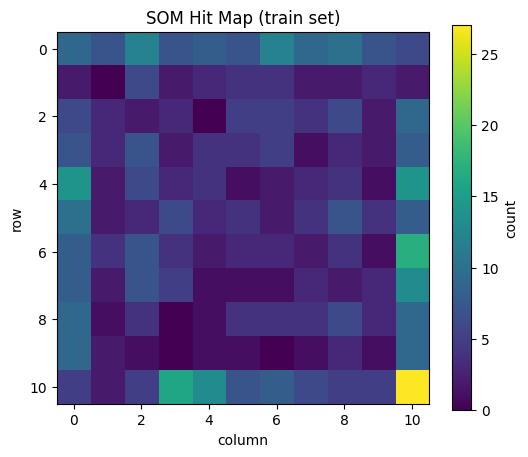

In [100]:

plt.figure(figsize=(6,5))
plt.title("SOM Hit Map (train set)")
plt.imshow(hits, interpolation="nearest")
plt.colorbar(label="count")
plt.xlabel("column"); plt.ylabel("row")
plt.show()

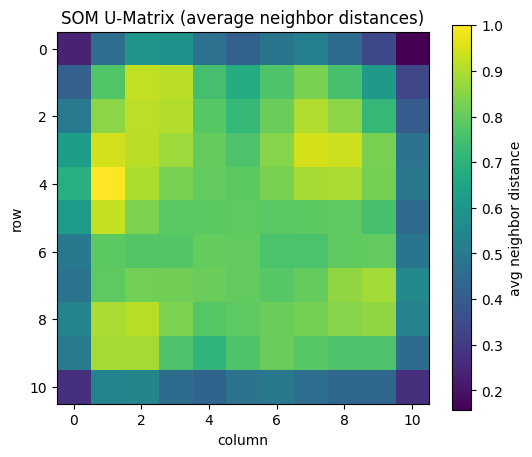

In [101]:
umatrix = som.distance_map()  # shape (m, n), average neighbor distances

plt.figure(figsize=(6,5))
plt.title("SOM U‑Matrix (average neighbor distances)")
plt.imshow(umatrix, interpolation="nearest")
plt.colorbar(label="avg neighbor distance")
plt.xlabel("column"); plt.ylabel("row")
plt.show()

In [102]:

# 1) Initialize the model
rf = RandomForestClassifier(
    n_estimators=400,          # number of trees
    max_depth=None,            # let trees grow until pure or min_samples_leaf reached
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,                  # use all CPU cores
    random_state=42
)

# 2) Fit on the augmented training set
rf.fit(X_train_aug, y_train)

# 3) Predict probabilities
rf_val_proba = rf.predict_proba(X_val_aug)[:, 1]
rf_test_proba = rf.predict_proba(X_test_aug)[:, 1]

# 4) Evaluate performance
rf_metrics = {
    "roc_auc_val": roc_auc_score(y_val, rf_val_proba),
    "f1_val@0.5": f1_score(y_test, (rf_val_proba >= 0.5).astype(int)),
    "roc_auc_test": roc_auc_score(y_test, rf_test_proba),
    "f1_test@0.5": f1_score(y_test, (rf_test_proba >= 0.5).astype(int)),
    "confusion_matrix_test": confusion_matrix(y_test, (rf_test_proba >= 0.5).astype(int)),
    "precision_test": precision_score(y_test, (rf_test_proba >= 0.5).astype(int)),
    "recall_test": recall_score(y_test, (rf_test_proba >= 0.5).astype(int)),
    "classification_report_test": classification_report(y_test, (rf_test_proba >= 0.5).astype(int), target_names=["No Default", "Default"]),
}
rf_metrics


{'roc_auc_val': 0.9935109289617486,
 'f1_val@0.5': 0.0,
 'roc_auc_test': 0.9832650273224044,
 'f1_test@0.5': 0.4,
 'confusion_matrix_test': array([[183,   0],
        [ 12,   4]]),
 'precision_test': 1.0,
 'recall_test': 0.25,
 'classification_report_test': '              precision    recall  f1-score   support\n\n  No Default       0.94      1.00      0.97       183\n     Default       1.00      0.25      0.40        16\n\n    accuracy                           0.94       199\n   macro avg       0.97      0.62      0.68       199\nweighted avg       0.94      0.94      0.92       199\n'}

In [103]:
thresholds = np.linspace(0.01, 0.99, 99)
scores = [f1_score(y_val, (rf_val_proba >= t).astype(int)) for t in thresholds]
best_t = thresholds[np.argmax(scores)]
print("Best threshold:", best_t)

rf_test_pred_opt = (rf_test_proba >= best_t).astype(int)
rf_test_metrics_opt = {
    "roc_auc_test_opt": roc_auc_score(y_test, rf_test_proba),
    "f1_test_opt@best_t": f1_score(y_test, rf_test_pred_opt),
    "confusion_matrix_test_opt": confusion_matrix(y_test, rf_test_pred_opt),
    "precision_test_opt": precision_score(y_test, rf_test_pred_opt),
    "recall_test_opt": recall_score(y_test, rf_test_pred_opt),
    "classification_report_test_opt": classification_report(y_test, rf_test_pred_opt, target_names=["No Default", "Default"]),
}
rf_test_metrics_opt

Best threshold: 0.29000000000000004


{'roc_auc_test_opt': 0.9832650273224044,
 'f1_test_opt@best_t': 0.8666666666666667,
 'confusion_matrix_test_opt': array([[182,   1],
        [  3,  13]]),
 'precision_test_opt': 0.9285714285714286,
 'recall_test_opt': 0.8125,
 'classification_report_test_opt': '              precision    recall  f1-score   support\n\n  No Default       0.98      0.99      0.99       183\n     Default       0.93      0.81      0.87        16\n\n    accuracy                           0.98       199\n   macro avg       0.96      0.90      0.93       199\nweighted avg       0.98      0.98      0.98       199\n'}

In [104]:
fpr, tpr, thresholds = roc_curve(y_test, rf_test_pred_opt)
results = {
    "threshold": float(best_t),
    "confusion_matrix": confusion_matrix(y_test, rf_test_pred_opt).tolist(),
    "accuracy": accuracy_score(y_test, rf_test_pred_opt),
    "precision": precision_score(y_test, rf_test_pred_opt),
    "recall": recall_score(y_test, rf_test_pred_opt),
    "f1_score": f1_score(y_test, rf_test_pred_opt),
    "roc_auc": roc_auc_score(y_test, rf_test_pred_opt),
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "roc_thresholds": thresholds.tolist(),    
}
with open("Results/SOM_RF_model_results.json", "w") as f:
    json.dump(results, f)

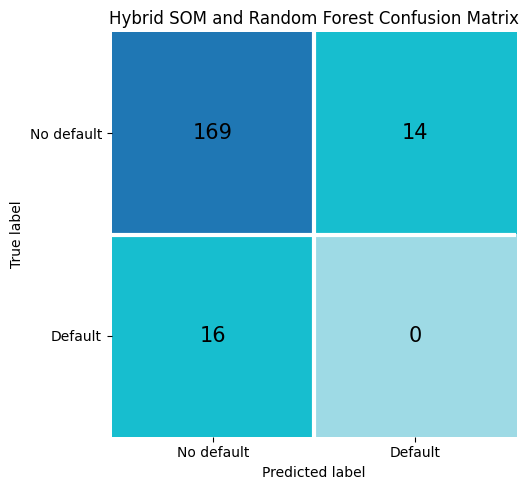

In [105]:

# Raw counts
cm = confusion_matrix(y_val, rf_test_pred_opt, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No default', 'Default'])
# Plot with custom settings
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(values_format='d', cmap='tab20_r', ax=ax, colorbar=0)

# Make the numbers bigger
for text in disp.text_.ravel():   # text_ stores the annotation objects
    text.set_fontsize(15)
    text.set_color('black')  # Set text color to black for better visibility
n_classes = cm.shape[0]
for i in range(1, n_classes):  
    ax.axhline(i - 0.5, color='white', linewidth=3)  # horizontal line
    ax.axvline(i - 0.5, color='white', linewidth=3)  # vertical line
for spine in ax.spines.values():
    spine.set_visible(False)

plt.title('Hybrid SOM and Random Forest Confusion Matrix')
plt.tight_layout()
plt.savefig("Plots/Confusion Matricies/SOM+RF_cm.png")
plt.show()

In [106]:

# 1) Initialize XGBoost
xgb = XGBClassifier(
    n_estimators=1000,           # large enough, early stopping will cut it
    learning_rate=0.05,          # small step size for smoother learning
    max_depth=6,                 # tree depth
    subsample=0.9,                # row sampling
    colsample_bytree=0.9,         # feature sampling
    reg_lambda=1.0,               # L2 regularization
    objective="binary:logistic",
    n_jobs=-1,
    tree_method="hist",           # "gpu_hist" if you have GPU
    random_state=42,
    eval_metric="auc"
)

# 2) Train with early stopping on validation set
xgb.fit(
    X_train_aug, y_train,
    eval_set=[(X_val_aug, y_val)],
    verbose=False
)

# 3) Predict probabilities
xgb_val_proba = xgb.predict_proba(X_val_aug)[:, 1]
xgb_test_proba = xgb.predict_proba(X_test_aug)[:, 1]

# 4) Evaluate at 0.5 threshold
xgb_test_pred = (xgb_test_proba >= 0.5).astype(int)

xgb_metrics = {
    "best_iteration": int(xgb.best_iteration) if hasattr(xgb, "best_iteration") else None,
    "roc_auc_val": roc_auc_score(y_val, xgb_val_proba),
    "f1_val@0.5": f1_score(y_val, (xgb_val_proba >= 0.5).astype(int)),
    "roc_auc_test": roc_auc_score(y_test, xgb_test_proba),
    "f1_test@0.5": f1_score(y_test, xgb_test_pred),
    "confusion_matrix_test": confusion_matrix(y_test, xgb_test_pred),
    "precision_test": precision_score(y_test, xgb_test_pred),
    "recall_test": recall_score(y_test, xgb_test_pred)
}

xgb_metrics


{'best_iteration': None,
 'roc_auc_val': 1.0,
 'f1_val@0.5': 0.9333333333333333,
 'roc_auc_test': 0.9996584699453552,
 'f1_test@0.5': 0.8571428571428571,
 'confusion_matrix_test': array([[183,   0],
        [  4,  12]]),
 'precision_test': 1.0,
 'recall_test': 0.75}

In [107]:
# --- Cell 7A: pick optimal threshold on validation (default: maximize F1) ---


def choose_threshold(y_true, y_proba, metric="f1", target_recall=None):
    """
    If metric='f1' -> pick t that maximizes F1 on validation.
    If metric='recall' with target_recall -> pick smallest t achieving that recall.
    """
    thresholds = np.linspace(0.01, 0.99, 99)

    if metric == "f1":
        scores = [f1_score(y_true, (y_proba >= t).astype(int)) for t in thresholds]
        i = int(np.argmax(scores))
        return float(thresholds[i]), float(scores[i])

    if metric == "recall" and target_recall is not None:
        pairs = []
        for t in thresholds:
            pred = (y_proba >= t).astype(int)
            r = recall_score(y_true, pred)
            p = precision_score(y_true, pred, zero_division=0)
            f = f1_score(y_true, pred)
            pairs.append((t, r, p, f))
        # choose the smallest threshold that meets/ exceeds target recall
        viable = [p for p in pairs if p[1] >= target_recall]
        if not viable:
            # fallback to the max recall achieved
            t, r, p, f = max(pairs, key=lambda x: x[1])
            return float(t), float(f)
        t, r, p, f = sorted(viable, key=lambda x: x[0])[0]
        return float(t), float(f)

    raise ValueError("Unsupported option")

# choose best threshold on validation for XGB
xgb_best_t, xgb_val_f1 = choose_threshold(y_val, xgb_val_proba, metric="f1")
print({"xgb_best_threshold": xgb_best_t, "xgb_val_f1": xgb_val_f1})


{'xgb_best_threshold': 0.09999999999999999, 'xgb_val_f1': 1.0}


In [108]:
# --- Cell 7B: evaluate XGBoost on TEST at the chosen threshold ---

xgb_test_pred_opt = (xgb_test_proba >= xgb_best_t).astype(int)

xgb_opt_metrics = {
    "threshold": xgb_best_t,
    "roc_auc_test": roc_auc_score(y_test, xgb_test_proba),         # unaffected by threshold
    "precision_test": precision_score(y_test, xgb_test_pred_opt, zero_division=0),
    "recall_test": recall_score(y_test, xgb_test_pred_opt),
    "f1_test": f1_score(y_test, xgb_test_pred_opt),
    "confusion_matrix_test": confusion_matrix(y_test, xgb_test_pred_opt)
}
xgb_opt_metrics


{'threshold': 0.09999999999999999,
 'roc_auc_test': 0.9996584699453552,
 'precision_test': 0.9411764705882353,
 'recall_test': 1.0,
 'f1_test': 0.9696969696969697,
 'confusion_matrix_test': array([[182,   1],
        [  0,  16]])}

In [109]:
fpr, tpr, thresholds = roc_curve(y_val, xgb_test_proba)
results = {
    "threshold": xgb_best_t,
    "confusion_matrix": confusion_matrix(y_test, xgb_test_pred_opt).tolist(),
    "accuracy": accuracy_score(y_test, xgb_test_pred_opt),
    "precision": precision_score(y_test, xgb_test_pred_opt),
    "recall": recall_score(y_test, xgb_test_pred_opt),
    "f1_score": f1_score(y_test, xgb_test_pred_opt),
    "roc_auc": roc_auc_score(y_test, xgb_test_pred_opt),
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "roc_thresholds": thresholds.tolist(),    
}
with open("Results/SOM_XGB_model_results.json", "w") as f:
    json.dump(results, f)

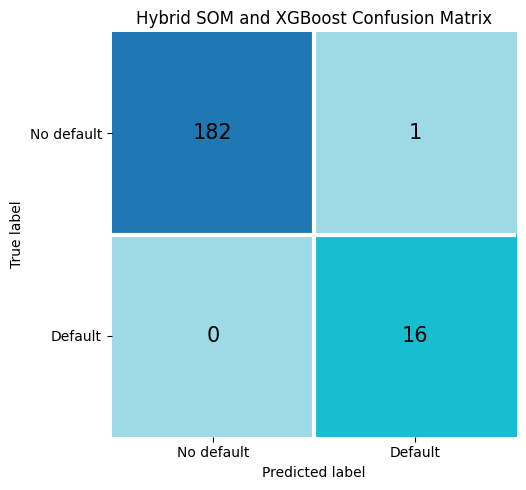

In [110]:


# Raw counts
cm = confusion_matrix(y_test, xgb_test_pred_opt, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No default', 'Default'])

# Plot with custom settings
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(values_format='d', cmap='tab20_r', ax=ax, colorbar=0)

# Make the numbers bigger
for text in disp.text_.ravel():   # text_ stores the annotation objects
    text.set_fontsize(15)
    text.set_color('black')  # Set text color to black for better visibility
n_classes = cm.shape[0]
for i in range(1, n_classes):  
    ax.axhline(i - 0.5, color='white', linewidth=3)  # horizontal line
    ax.axvline(i - 0.5, color='white', linewidth=3)  # vertical line
for spine in ax.spines.values():
    spine.set_visible(False)
plt.title('Hybrid SOM and XGBoost Confusion Matrix')
plt.savefig("Plots/Confusion Matricies/SOM+XGB_cm.png")
plt.tight_layout()
plt.show()